In [12]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from scheduler import NoiseScheduler

# Get data

In [13]:
batch_size = 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

next(iter(trainloader))[0].shape

torch.Size([1, 1, 28, 28])

# Noise Scheduler

### Formulas Used in NoiseScheduler

#### 1. Betas Initialization:
$$
\beta_i = \text{linspace}(\text{beta\_start}, \text{beta\_end}, t)
$$

#### 2. Alphas Calculation:
$$
\alpha_i = 1 - \beta_i
$$

#### 3. Cumulative Product of Alphas:
$$
\overline{\alpha_t} = \prod_{j=1}^{i} \alpha_j
$$

#### 4. Square Root of Cumulative Alpha and Complement:
$$
\sqrt{\overline{\alpha_t}} = \sqrt{\overline{\alpha_t}}
$$
$$
\sqrt{1 - \overline{\alpha_t}} = \sqrt{1 - \overline{\alpha_t}}
$$

---

### Adding Noise (Method `add_noise`)

The noisy input is computed as:
$$
\tilde{x}_t = \sqrt{\overline{\alpha_t}} \cdot x + \sqrt{1 - \overline{\alpha_t}} \cdot \epsilon
$$

Where:
$$
\sqrt{\overline{\alpha_t}} \text{ and } \sqrt{1 - \overline{\alpha_t}} \text{ are broadcasted to match the batch dimensions.}
$$

---

### Sampling the Previous Timestep (Method `sample_prev_timestep`)

#### (a) Compute $x_0$ (Reconstructed Signal):
$$
x_0 = \frac{x_t - \sqrt{1 - \overline{\alpha_t}} \cdot \text{noise\_pred}}{\sqrt{\overline{\alpha_t}}}
$$

Clamp $x_0$ to the range $[-1, 1]$:
$$
x_0 = \text{clamp}(x_0, -1, 1)
$$

#### (b) Compute Mean for Sampling:
$$
\text{mean} = \frac{x_t - \frac{\beta_t \cdot \text{noise\_pred}}{\sqrt{1 - \overline{\alpha_t}}}}{\sqrt{\alpha_t}}
$$

#### (c) Compute Variance for $t > 0$:
$$
\text{variance} = \frac{1 - \overline{\alpha_{t-1}}}{1 - \overline{\alpha_t}} \cdot \beta_t
$$

Standard deviation ($\sigma$):
$$
\sigma = \sqrt{\text{variance}}
$$

#### (d) Add Noise to the Mean (for $t > 0$):
$$
\tilde{x}_{t-1} = \text{mean} + \sigma \cdot z
$$

Where$$ z \sim \mathcal{N}(0, I) $$is standard normal noise.


In [14]:
test = NoiseScheduler(4, 0.1, 0.9)
test_batch = next(iter(trainloader))[0]
test_noise = torch.randn(test_batch.shape)
test_t = 2
test_time_t=test.add_noise(test_batch, test_noise, test_t)


In [15]:
test_time_minus_1, test_x0 = test.sample_prev_timestep(test_time_t, test_noise, test_t)

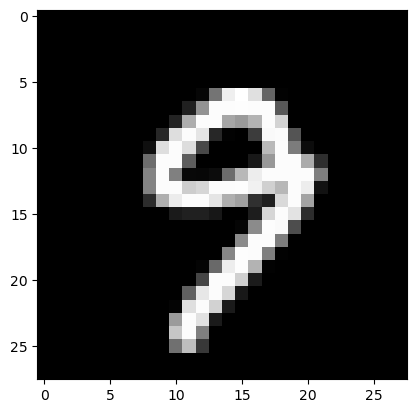

In [16]:
#plot test_batch
plt.imshow(test_x0.squeeze().numpy(), cmap='gray')
plt.show()

In [ ]:
emb_single

tensor([[8.4147e-01, 5.3317e-01, 3.1098e-01, 1.7689e-01, 9.9833e-02, 5.6204e-02,
         3.1618e-02, 1.7782e-02, 9.9998e-03, 5.6234e-03, 3.1623e-03, 1.7783e-03,
         1.0000e-03, 5.6234e-04, 3.1623e-04, 1.7783e-04, 5.4030e-01, 8.4601e-01,
         9.5042e-01, 9.8423e-01, 9.9500e-01, 9.9842e-01, 9.9950e-01, 9.9984e-01,
         9.9995e-01, 9.9998e-01, 9.9999e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00]])